In [1]:
import os
import cv2
from PIL import Image
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
from dataset import CelebaDataset, transform, augment, inverse_normalize
from model import VAE

set_random_seed(seed=0)

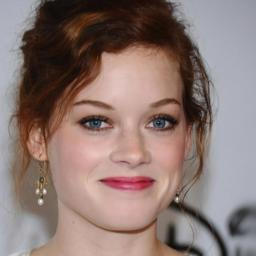

In [2]:
img = Image.open(f"data/celeba_hq_256/00555.jpg")
img

In [3]:
celeba_dataset = CelebaDataset(folder_path='data/celeba_hq_256', transform=transform, augment=augment)
dataloader = DataLoader(dataset=celeba_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)

# celeba_dataset.__getitem__(0)
for x in dataloader:
    print(x.shape)
    break

torch.Size([64, 3, 128, 128])


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VAE(
    input_channels=3,
    latent_channels=512,
).to(device)

In [ ]:
epochs = 20

if not os.path.exists('weights'):
    os.makedirs('weights')

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for epoch in range(epochs):
    for batch, x in enumerate(dataloader):
        
        x = x.to(device)
        x_hat, mu, log_var = model(x)
        
        reconstruction_loss = model.reconstruction_loss(x=x, x_hat=x_hat)
        kl_divergence = model.kl_divergence(mu=mu, sd=torch.exp(0.5*log_var))
        total_loss = reconstruction_loss + kl_divergence
        
        optimizer.zero_grad()
        total_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=50)
        optimizer.step()
        
        if batch % 50 == 0:
            print(
                f"epoch={epoch}",
                f"batch={batch:03d}",
                f"mse={reconstruction_loss.item():.3f}",
                f"kl={kl_divergence.item():.3f}",
                f"total_loss={total_loss.item():.3f}"
            )
    print()
    torch.save(model.state_dict(), f"weights/model_epoch_{epoch:02d}.pt")

# Morphing

In [11]:
celeba_dataset_pure = CelebaDataset(
    folder_path='data/celeba_hq_256', 
    transform=transform, 
    augment=None
)

In [12]:
state_dict = torch.load(f='weights/model_epoch_19.pt', map_location=torch.device(device))
model.load_state_dict(state_dict=state_dict)
model.eval()

VAE(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (layer3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (layer4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (layer5): Sequential(
      (0): Conv2d(256, 

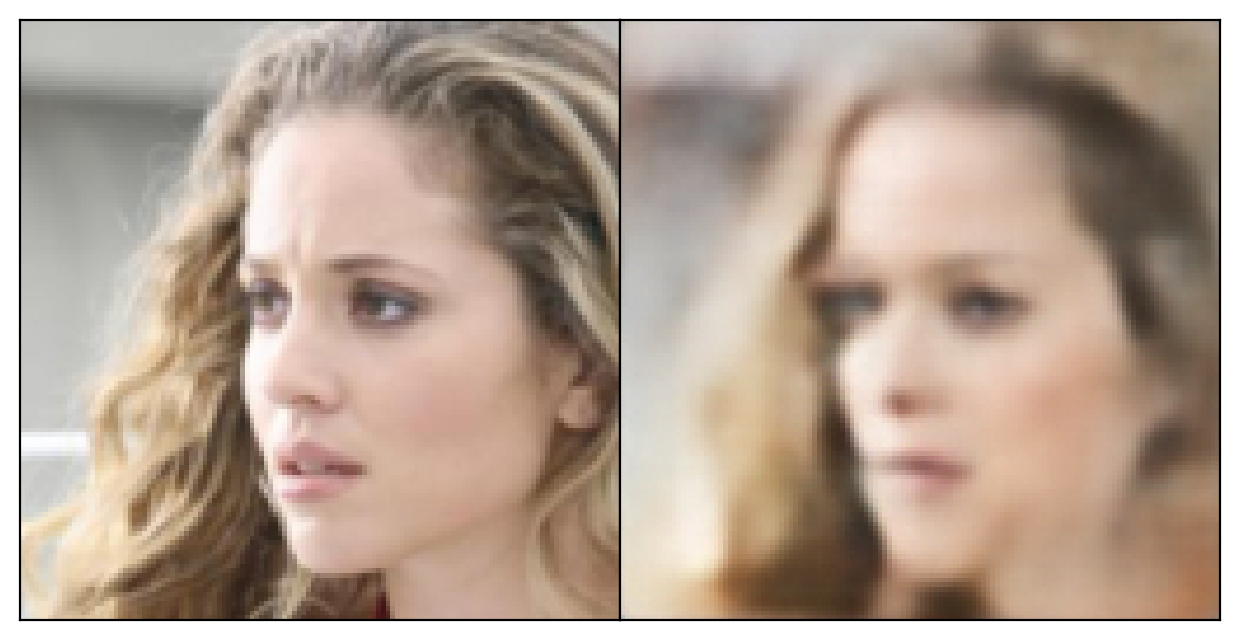

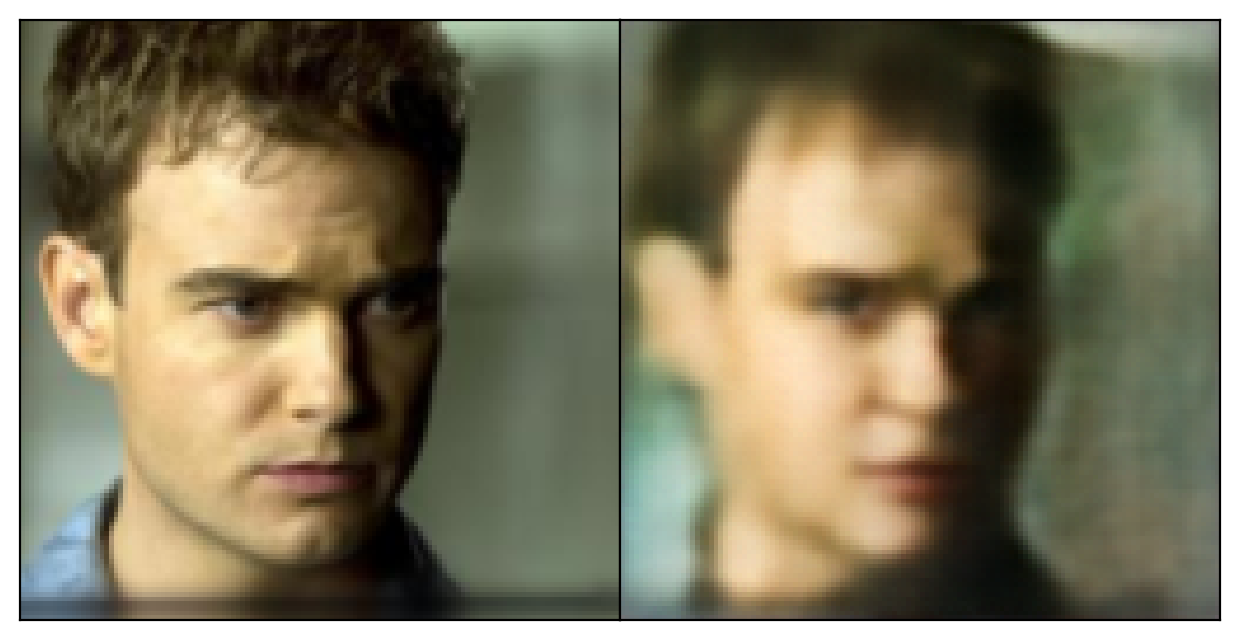

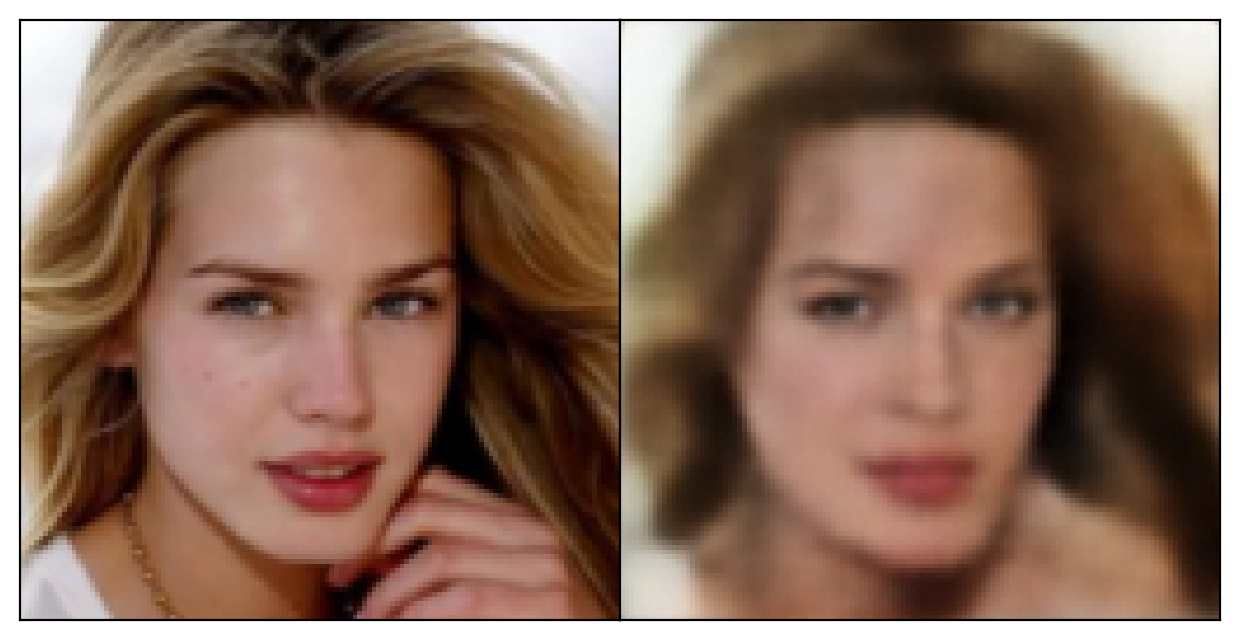

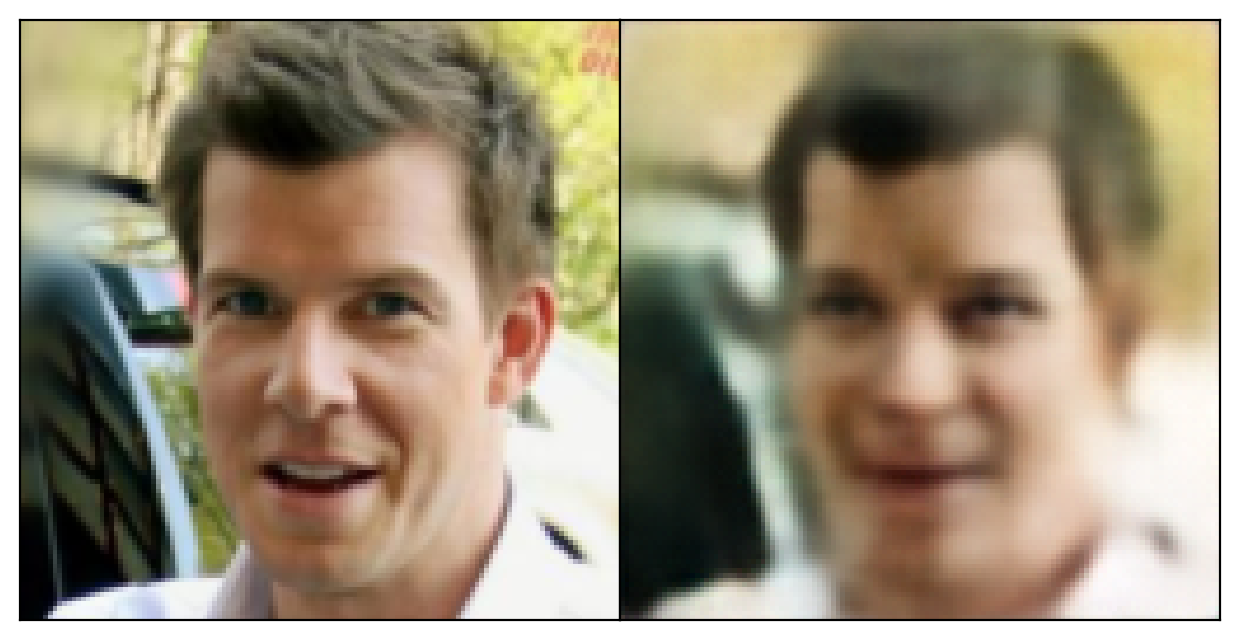

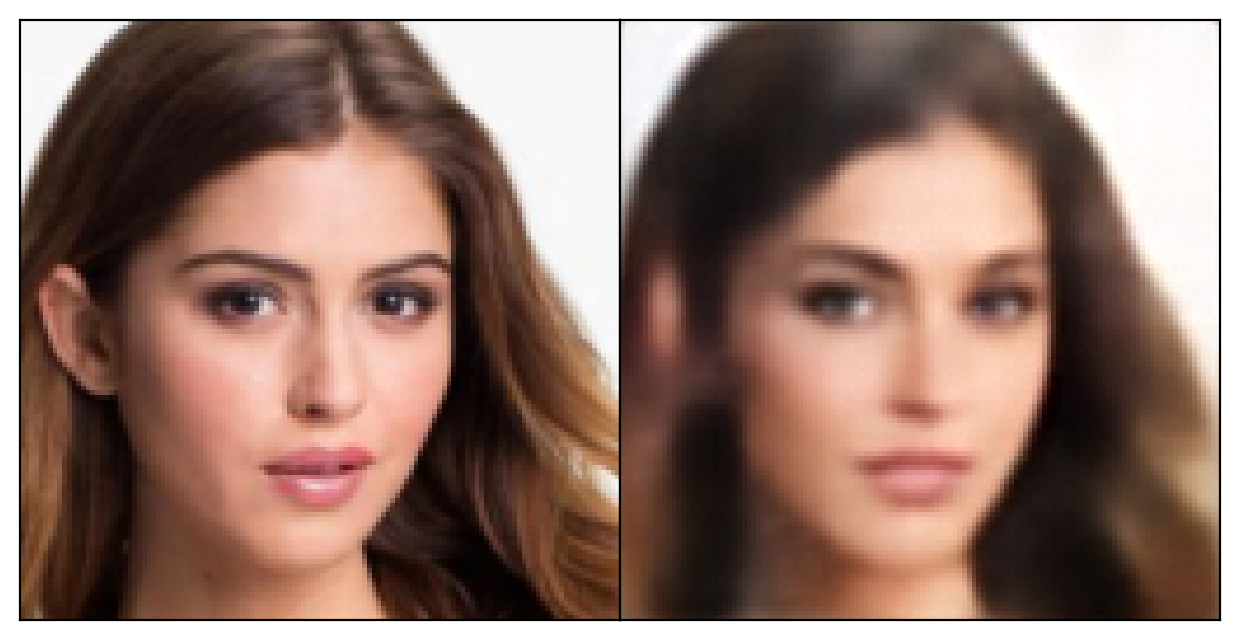

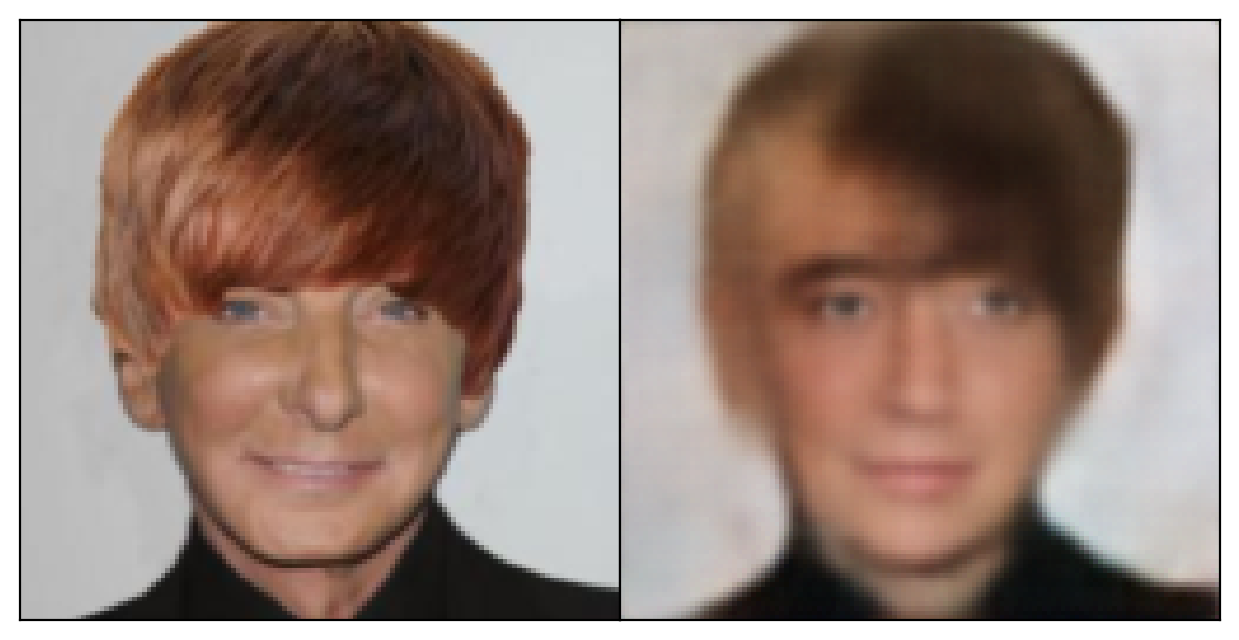

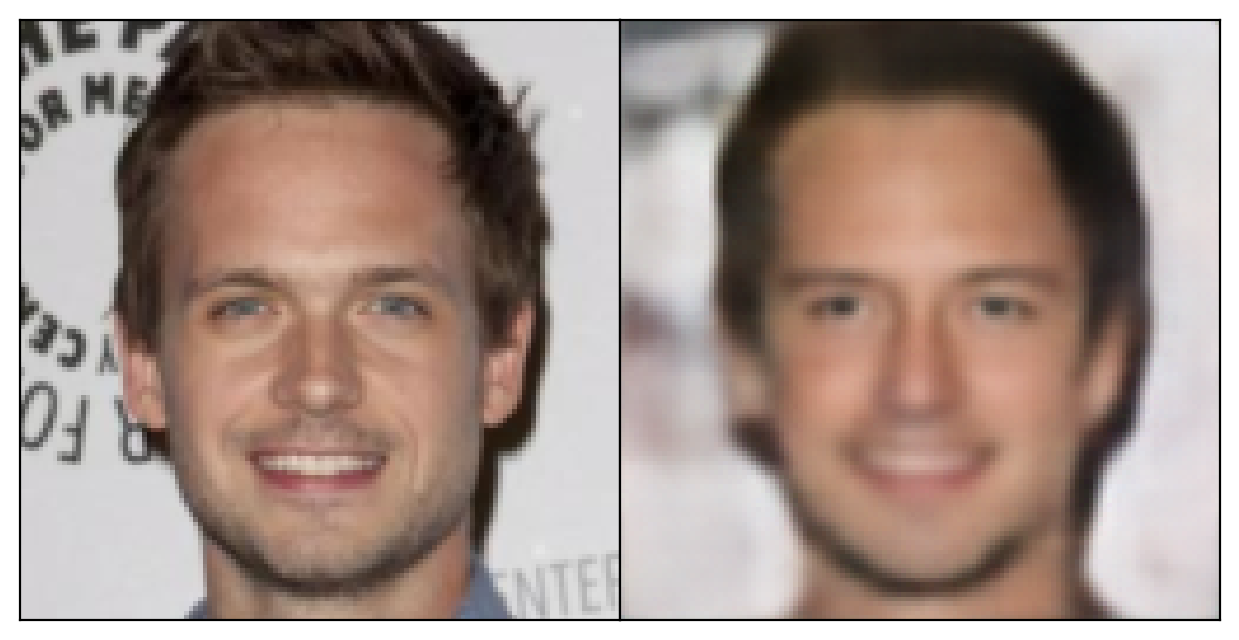

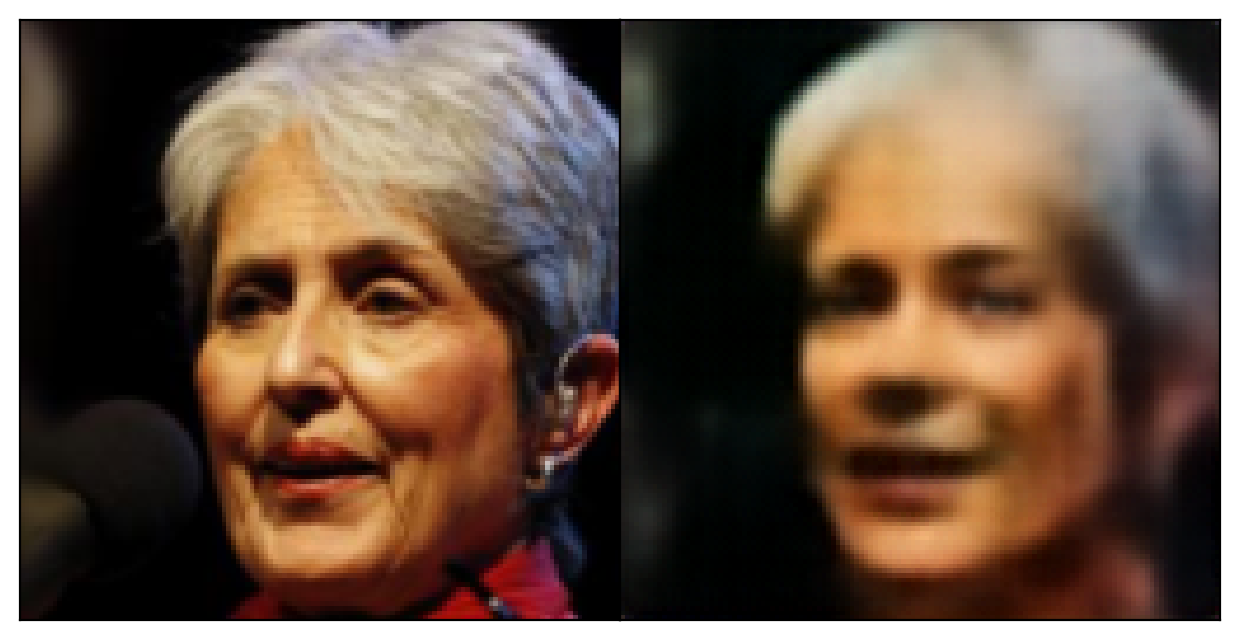

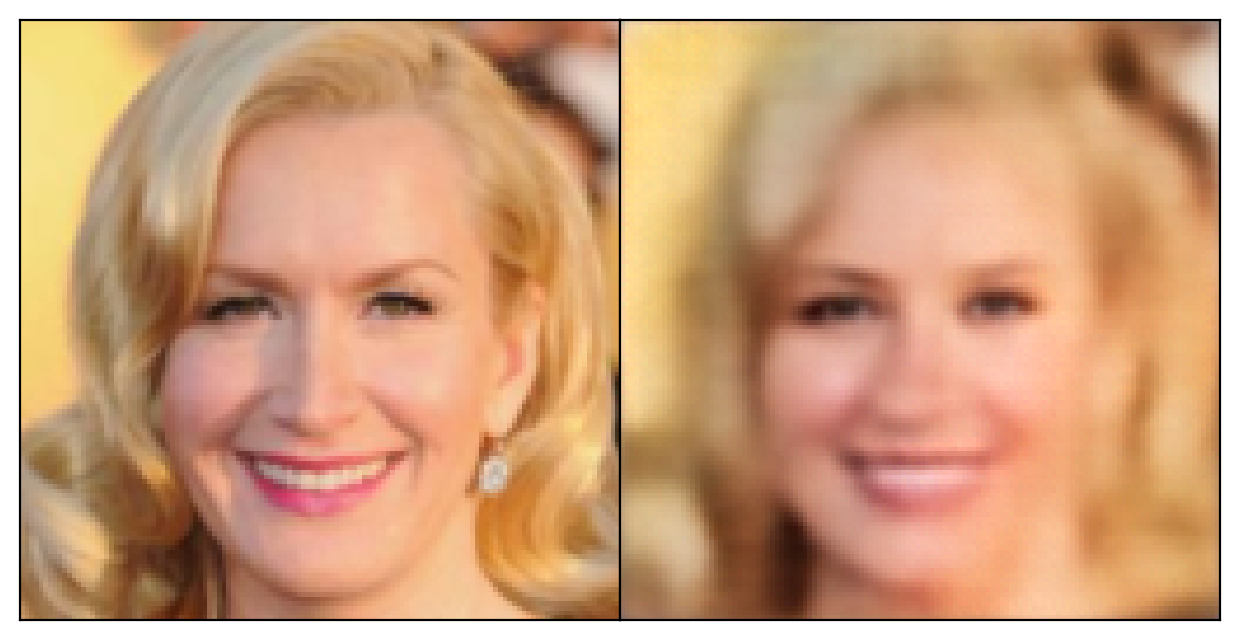

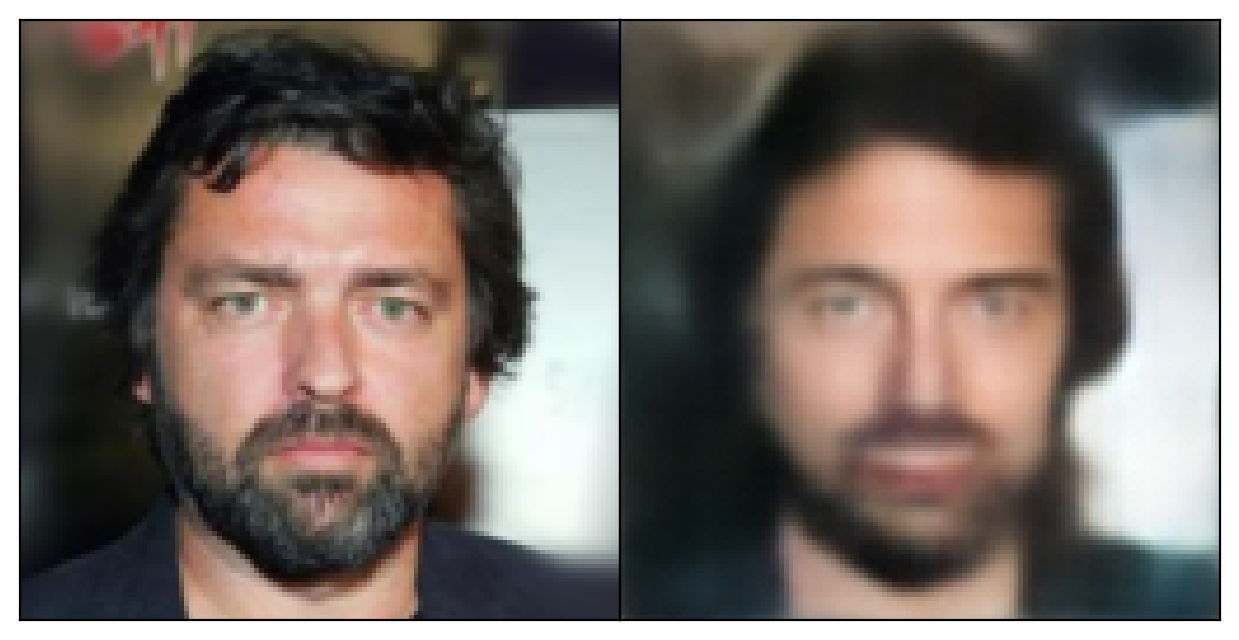

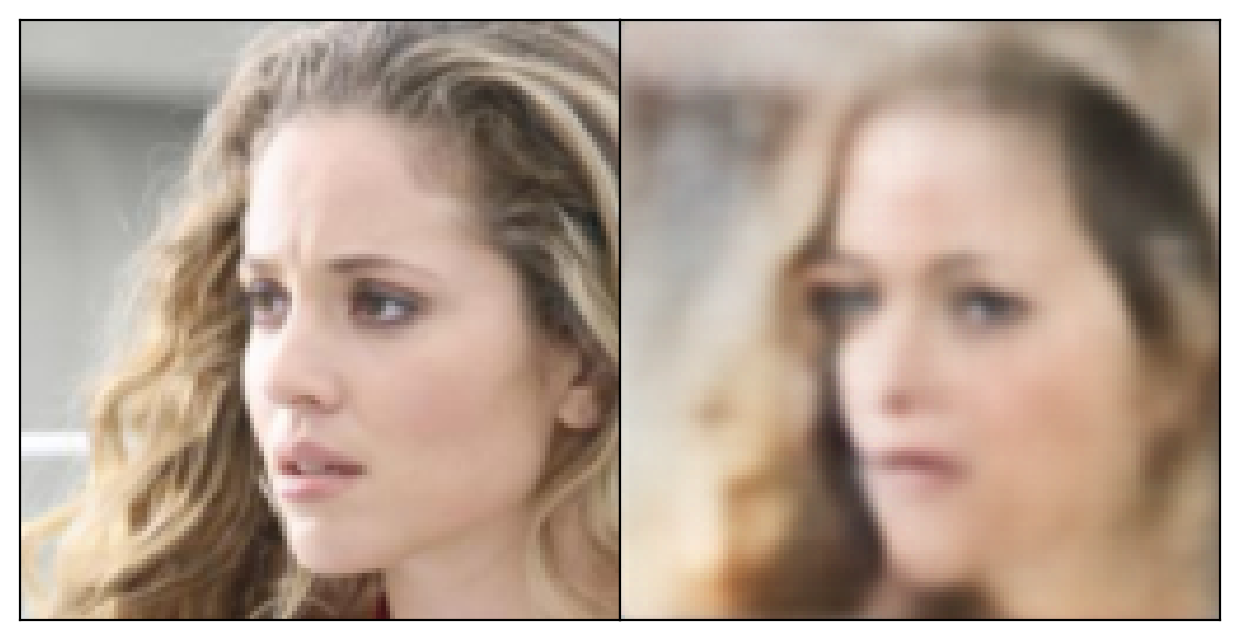

In [37]:
set_random_seed(seed=0)
imgs = [celeba_dataset_pure[r] for r in random.sample(range(30_000), 10)]
imgs.append(imgs[0])

for img in imgs:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(inverse_normalize(img).permute(1,2,0));

    img_hat, _, _ = model(img.unsqueeze(0).to(device))
    ax2.imshow(inverse_normalize(img_hat).view(3,128,128).permute(1,2,0).cpu().detach());
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()

In [318]:
params = []
for img in imgs:
    mu, log_var = model.encoder(img.unsqueeze(0).to(device))
    params.append((mu, log_var))

In [319]:
eps = torch.randn_like(mu)

STEPS = 30

decoded = []
for i in range(len(params) - 1):
    mu_prev, log_var_prev = params[i]
    mu_next, log_var_next = params[i+1]
    
    mu_delta = (mu_next - mu_prev) / STEPS
    log_var_delta = (log_var_next - log_var_prev) / STEPS

    mu_increment = 0
    log_var_increment = 0
    for i in range(STEPS):
        
        mu = mu_prev + mu_increment
        mu_increment += mu_delta
        
        log_var = log_var_prev + log_var_increment
        log_var_increment += log_var_delta

        z = mu + torch.exp(0.5*log_var) * eps
        output = model.decoder(z)
        output = inverse_normalize(output).view(3,128,128).permute(1,2,0).cpu().detach()
        decoded.append(output)

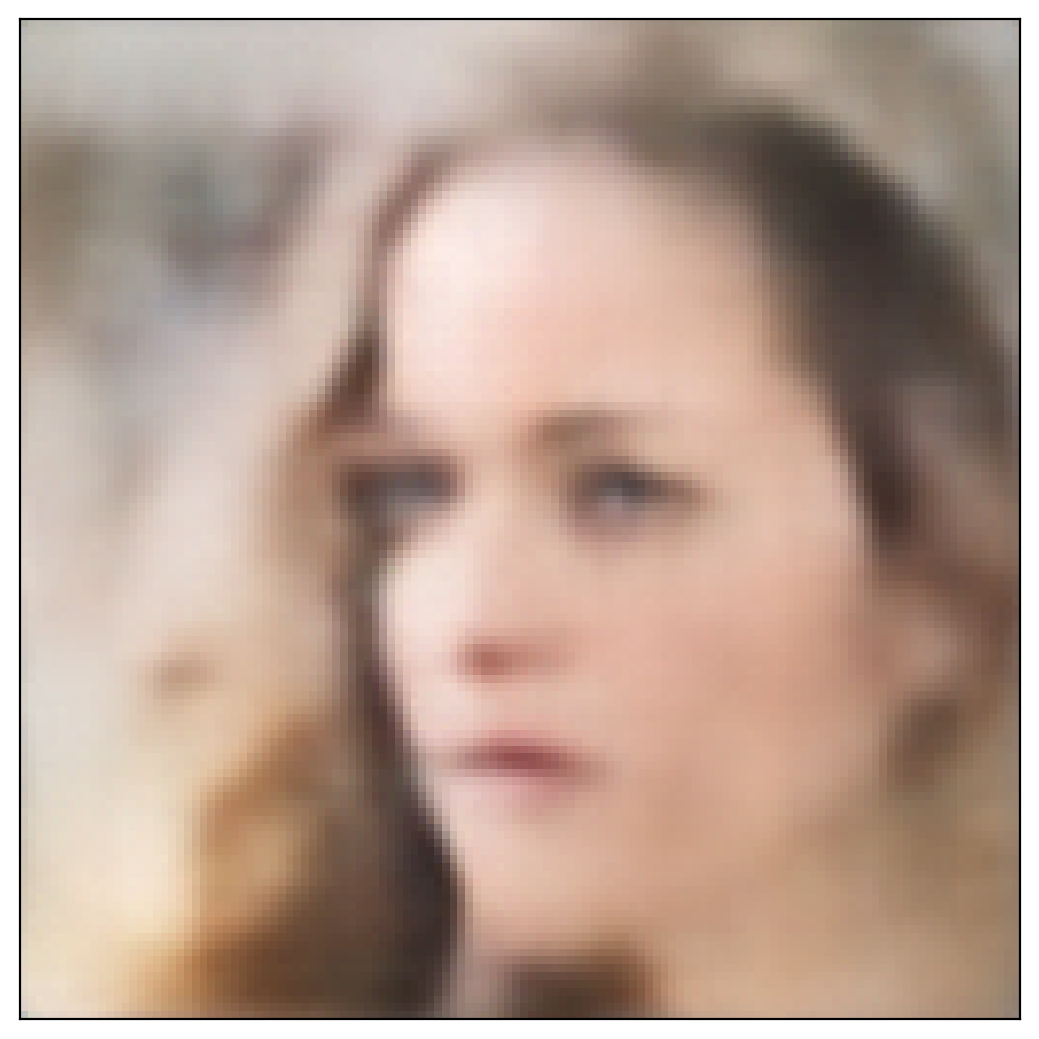

In [320]:
fig, ax = plt.subplots(figsize=(5,5))
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

def animate(i):
    ax.clear()
    f = ax.imshow(decoded[i])
    ax.set_xticks([])
    ax.set_yticks([])
    return f

ani = FuncAnimation(fig=fig, func=animate, repeat=True, frames=len(decoded))
ani.save("animation_celeba.gif", dpi=100, writer=PillowWriter(fps=10))

# Generate from noise

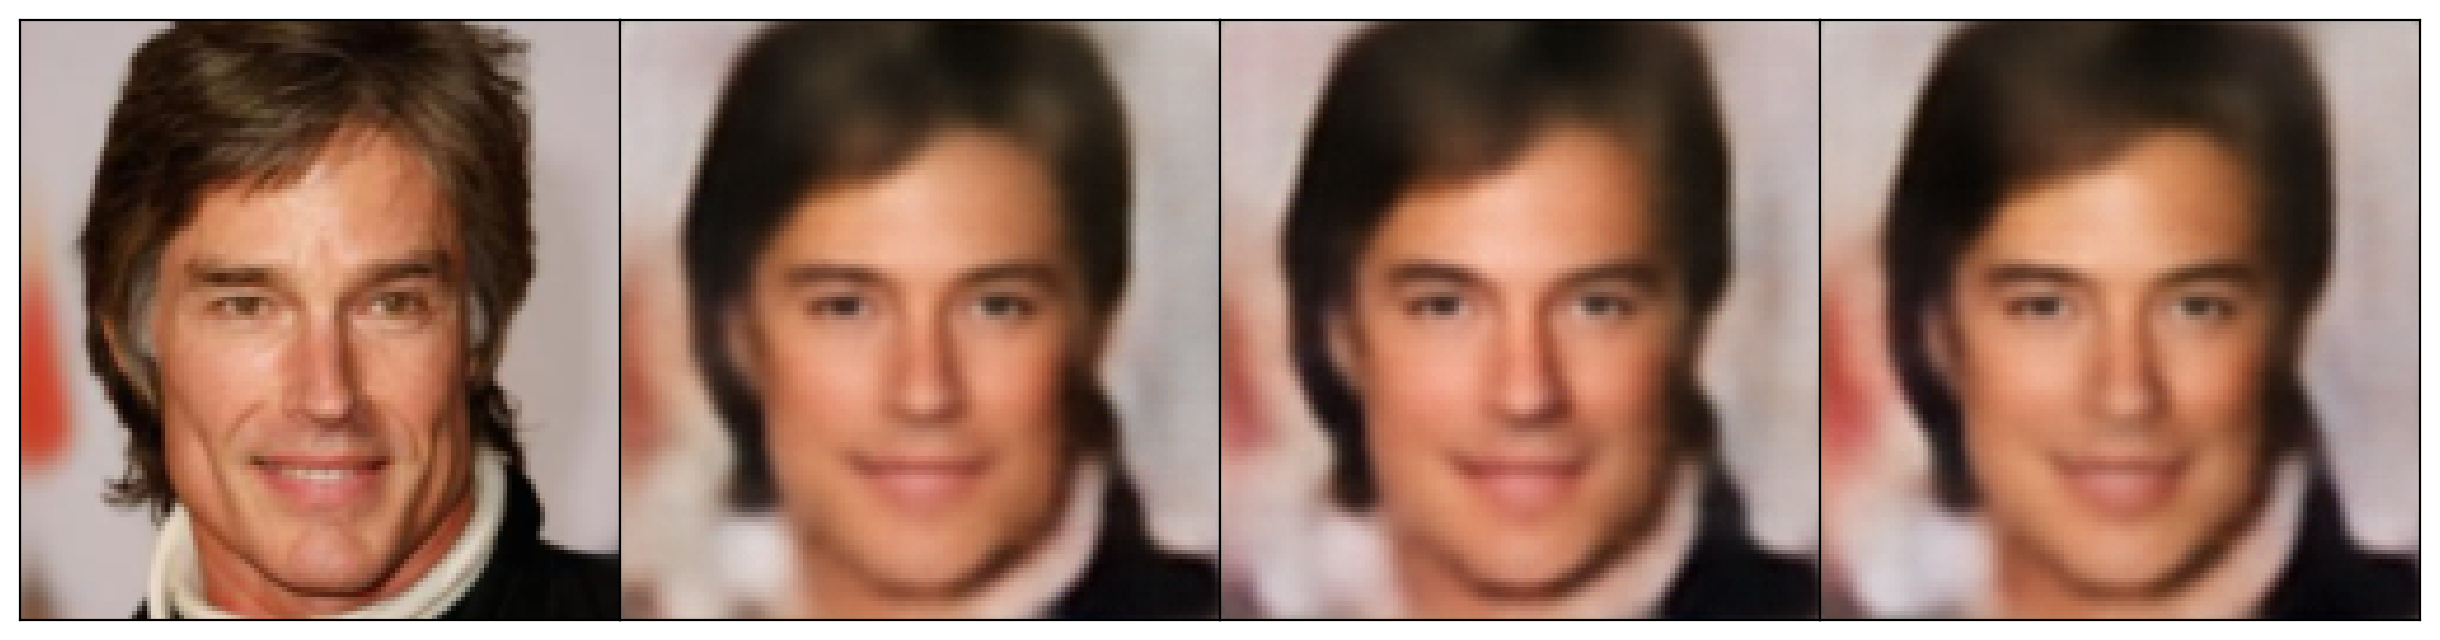

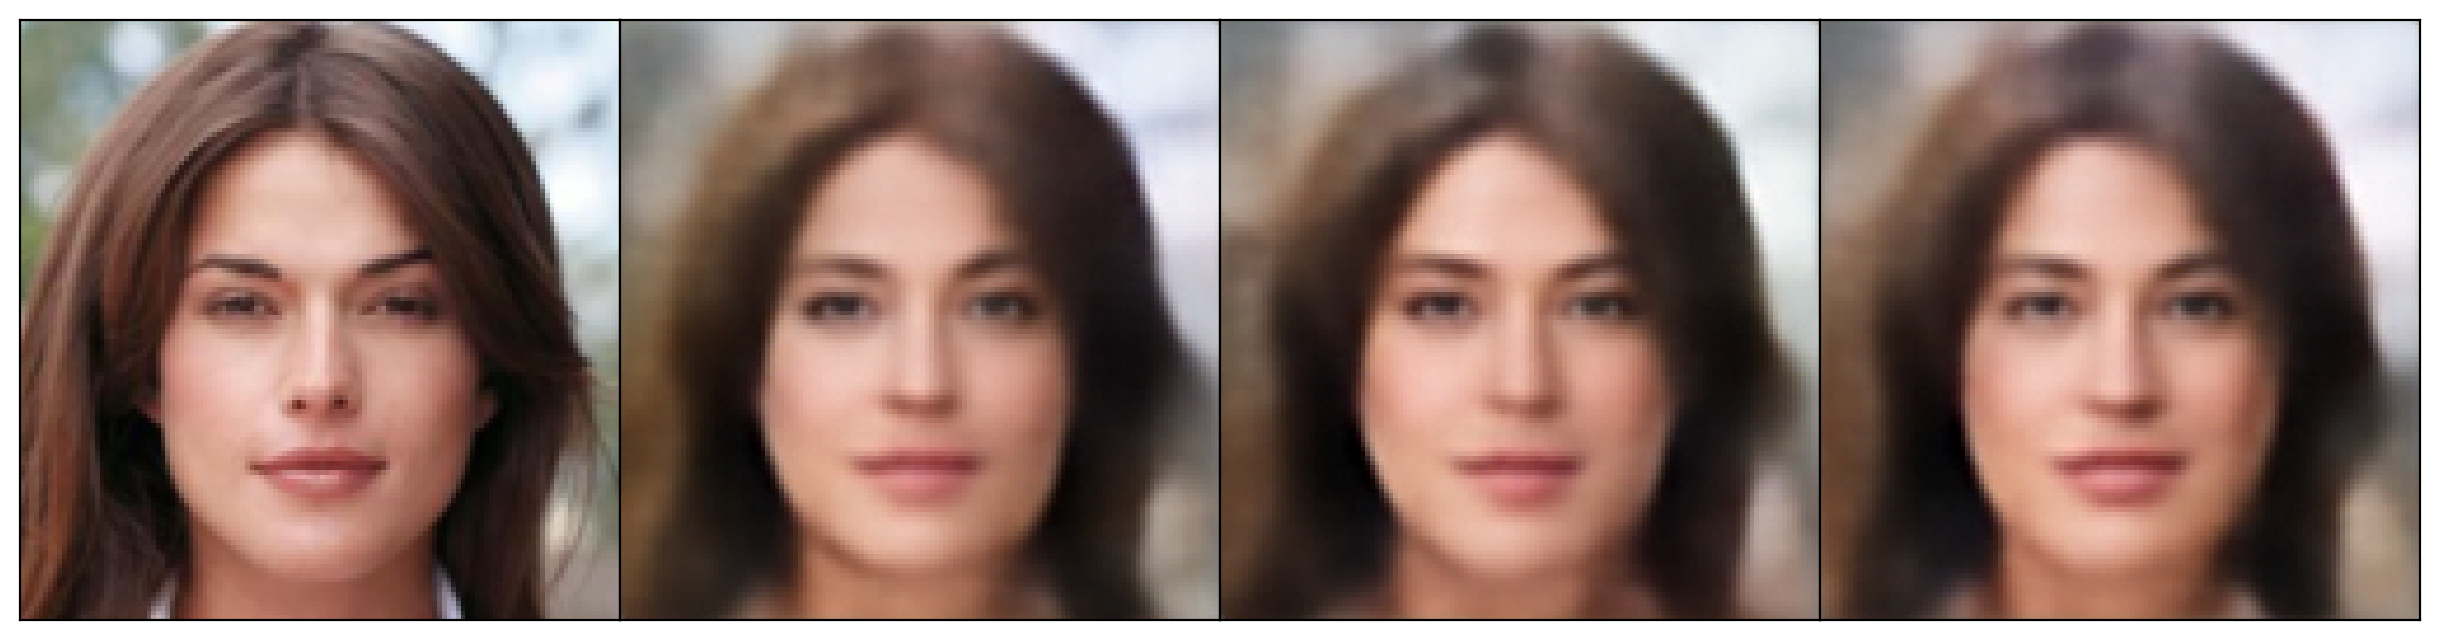

In [362]:
set_random_seed(seed=555)
imgs = [celeba_dataset_pure[r] for r in random.sample(range(30_000), 2)]

with torch.no_grad():
    for img in imgs:
        mu, log_var = model.encoder(img.unsqueeze(0).to(device))
        
        fig, axes = plt.subplots(1, 4, figsize=(12,3))
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

        axes[0].imshow(inverse_normalize(img).permute(1,2,0));
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        for i in range(1,4):

            eps = torch.randn_like(mu)
            z = mu + torch.exp(0.5*log_var) * eps
            out = model.decoder(z).view(1, 3, 128, 128)

            axes[i].imshow(inverse_normalize(out).view(3,128,128).permute(1,2,0));
            axes[i].set_xticks([])
            axes[i].set_yticks([])